<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/testing/DDPG/DC_Microgrid_gym_safe_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct current Microgrid



In the we present the kron reduced model for a 4-node (connected) Direct Current Microgrid:

Analytical Model

\begin{align}
		\begin{split}
            L\dot{I}_{t} & =- V-R_tI + V_s \cdot u\\
            L_t\dot{I} & = - R I_t -\mathcal{B}^\top V\\
            C\dot{V} & = I + \mathcal{B}I_t - GV,		
		\end{split}
\end{align}

The parameters are:


*   L - DGU Inductance
*   C - DGU Capacitance
*   R - DGU Series Resistance
*   G - DGU Load Impedance
*   $V_s$ - DGU Source Voltage
*   $L_t$ - Line Inductances
*   $R_t$ - Line Resistances

The state variables:
*  $I\geq 0$ - Source current through the inductors
*  $V\geq 0$ - load voltage across the Capacitors
* $I_t \in \mathbb{R}^4$ - Line currents through the inductors

Input:
* $u\in (0,1)$ - duty-ratio
* To symmetrize the action space, we use transformed the input to $a = 2u -1$ $\implies a \in (-1,1)$.

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - \|V-V_d\|_2^2 
\end{align}

## For 

#Gym Model

In [1]:
# Imports
import networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt

import argparse

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential, layers
import datetime
from scipy.io import savemat
import os
import argparse
import pprint as pp

In [2]:
class Buck_micrgrid(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """ 
    metadata = {'render.modes': ['console']}

    def __init__(self, dt = 1e-5):
        super(Buck_micrgrid, self).__init__()

        #parameters 1+
        self.Vs = np.array([400, 400, 400, 400])
        self.L = np.diag(np.array([1.0, 1.0, 1.0, 1.0]))#np.diag(np.array([1.8, 2.0, 3.0, 2.2])*1e-3)
        self.C = np.diag(np.array([1.0, 1.0, 1.0, 1.0]))#np.diag(np.array([2.2, 1.9, 2.5, 1.7])*1e-3)
        self.R = np.diag(np.array([1.0, 1.0, 1.0, 1.0]))#np.diag(np.array([1.5, 2.3, 1.7, 2.1])*0)
        self.G = np.diag(np.array([0.1, 0.1, 0.1, 0.1]))# np.diag(1/np.array([16.7, 50, 16.7, 20]))

        self.Lt = np.diag(np.array([2.1, 2, 3, 2.2])*1e-3)
        self.Rt = np.diag(np.array([7, 5, 8, 6])*1e-2)

        """
        W = inv(diag([0.4 0.2 0.15 0.25]));
        D = 100*[1 -1 0 0; -1 2 -1 0; 0 -1 2 -1; 0 0 -1 1];
        B = [-1 0 0 -1;
              1 -1 0 0; 
              0 1 -1 0; 
              0 0 1 1  ];
        """
        #Graph structure
        self.inc_mat = np.array([[-1, 0, 0, -1],
                          [1, -1, 0, 0], 
                          [0, 1, -1, 0], 
                          [0, 0, 1, 1  ]])
        self.adj_mat = (np.dot(self.inc_mat, self.inc_mat.T)-2*np.eye(4)).astype(int)
        self.Graph = nx.from_numpy_matrix(self.adj_mat)
        self.pos = nx.spring_layout(self.Graph) #networkx.random_layout(G)
        self.options = {
            'node_color': 'red',
            'node_size': 1300,
            'width': 1,
            'arrowstyle': '-|>',
            'arrowsize': 12,
            'pos' : self.pos}
        

        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-6
        self.T = dt

        #the steady-state equilibrium of the system is
        self.Vdes = np.array([230, 230, 230, 230])
        self.Itdes = -np.dot(np.linalg.inv(self.Rt), np.dot(self.inc_mat.T, self.Vdes))
        self.Ides = np.dot(self.G, self.Vdes) - np.dot(self.inc_mat, self.Itdes)

        self.udes = (1/self.Vs) * (np.dot(self.R, self.Ides) + self.Vdes)
        self.action_des = 2 * self.udes - 1
        if any(self.Vs <= self.Vdes):
            raise ValueError("for buck converter desired voltage should be less the source Voltage: Vdes < Vs ")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        #However, RL algos work with symmetric control actions 
        # hence we transform the action space between -1 and 1
        # action = 2*duty-ratio -1
        #duty-ratio = 0.5*(action + 1)
        #lists to save the states and actions 
        self.state_trajectory = []
        self.action_trajectory = []
        self.count_steps = 0 # counts the number of steps taken

        self.action_space = spaces.Box(low=np.array([-1, -1, -1, -1]), high=np.array([+1, +1, +1, +1], dtype=np.float64))
        
        low_obs = np.full(shape = (12,), fill_value = -np.inf, dtype=np.float64)
        high_obs = np.full(shape = (12,), fill_value = np.inf, dtype=np.float64)

        self.observation_space = spaces.Box(low = low_obs, high = high_obs, dtype=np.float64)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = np.random.uniform(low = self.Ides*0.9, high = self.Ides*1.1)
        It = np.random.uniform(low = self.Itdes*0.9, high = self.Itdes*1.1)
        V = np.random.uniform(low = self.Vdes*0.9, high = self.Vdes*1.1)
        self.state = np.concatenate([I, It, V])

    def _set_state(self, I, It, V):
        #using this function we can change the state variable
        self.state = np.concatenate([I, It, V])

    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Itdes, self.Vdes, self.udes, self.action_des])

    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        self.state_trajectory = []
        self.action_trajectory = []
        self.count_steps = 0
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):

        temp_u = (1 + action[0])/2

        u = np.clip(temp_u, 0, 1)

        i = self.state[0:4]
        it = self.state[4:8]
        v = self.state[8:12]

        didt = np.dot(self.R, i) + v - u*self.Vs
        didt = -np.dot(np.linalg.inv(self.L), didt)

        ditdt = np.dot(self.Rt, it) + np.dot(self.inc_mat.T, v)
        ditdt = -np.dot(np.linalg.inv(self.Lt), ditdt)

        dvdt = i + np.dot(self.inc_mat, it)- np.dot(self.G, v)
        dvdt = np.dot(np.linalg.inv(self.C), dvdt)



        new_i = i + self.T * didt
        new_it = it + self.T * ditdt
        new_v = v + self.T * dvdt

        self.state = np.concatenate([new_i, new_it, new_v]).astype(np.float32)

        # normalize the rewards
        self.reward = -np.mean((new_v-self.Vdes)**2)
        self.done = False

        self.state_trajectory.append(self.state)
        self.action_trajectory.append(action)
        
        self.count_steps += 1
        return self.state, self.reward, self.done, {}

    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0:4] - self.Ides
        eit = self.state[4:8] - self.Itdes
        ev = self.state[8:12] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, It-Itdes = {:.2f}, V-Vdes = {:.2f}".format(ei, eit, ev))

    def network_graph(self):
        networkx.draw_networkx(self.Graph, arrows=True, **self.options)

    def get_node(self, node_index):
        # use this after using step function
        # given index of the node, the function will return its current states i.e [current, voltage, the net line curent] and its reward 
        #node_index : 0 - 3
        i = self.state[0:4]
        v = self.state[8:12]
        o_it = np.dot(self.inc_mat, self.state[4:8])
        node_reward = -(v[node_index]- self.Vdes[node_index])**2
        node_state = np.array([i[node_index], v[node_index]])
        return node_state, node_reward

    def close(self):
        pass
        
    def plot(self, savefig_filename=None):
        #number_of_colors = data.shape[1]
        #color = ['r', 'b']
        state_dim = self.observation_space.shape[0]
        act_dim = self.action_space.shape[0]
        des1 = np.array([self.Ides, self.Itdes, self.Vdes, self.action_des])
        title_nodes = ['Node - 1', 'Node - 2', 'Node - 3', 'Node - 4']
        title_state = ['DGU current', 'Line current', 'Load Voltage', 'action']
        test_steps = self.count_steps
        time = np.array(range(test_steps), dtype=np.float32)*self.T
        test_obs_reshape = np.concatenate(self.state_trajectory).reshape((test_steps ,self.observation_space.shape[0]))
        #print(np.shape(self.action_trajectory),self.action_trajectory)
        test_act_reshape = np.concatenate(self.action_trajectory).reshape((test_steps ,self.action_space.shape[0]))
        test_reshaped = np.concatenate([test_obs_reshape, test_act_reshape], axis = 1)

        temp = 0
        fig, ax = plt.subplots(nrows=4, ncols=4, figsize = (12,12))
        for j in range(0, 4):
            des = des1[j]
            #fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (24,4))
            time = np.array(range(test_reshaped.shape[0]), dtype=np.float32)*self.T
            for i in range(4):
                ax[j, i].plot(time, test_reshaped[:, i+temp])
                ax[j, i].plot(time, np.full(test_reshaped[:,i+temp].shape[0], des[i]), marker = '.')
                #ax[j, i].set_ylim(des[i]-50, des[i]+50)
                ax[j, i].set_title(title_nodes[i] + ' :  ' + title_state[j], fontsize=10)
                ax[j, i].set_xlabel('Time', fontsize=8)
            temp = temp + 4
            fig.suptitle(title_state[j], fontsize=10)
        #plt.show()
        if savefig_filename is not None:
            assert isinstance(savefig_filename, str), \
                    "filename for saving the figure must be a string"
            plt.savefig(savefig_filename)
        else:
            plt.show()
            

#Testing:

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ 21.81904928  21.83819339  22.86411252  23.98764663   0.
   0.           0.           0.         221.46944967 216.07018332
 222.75705851 239.59035036]


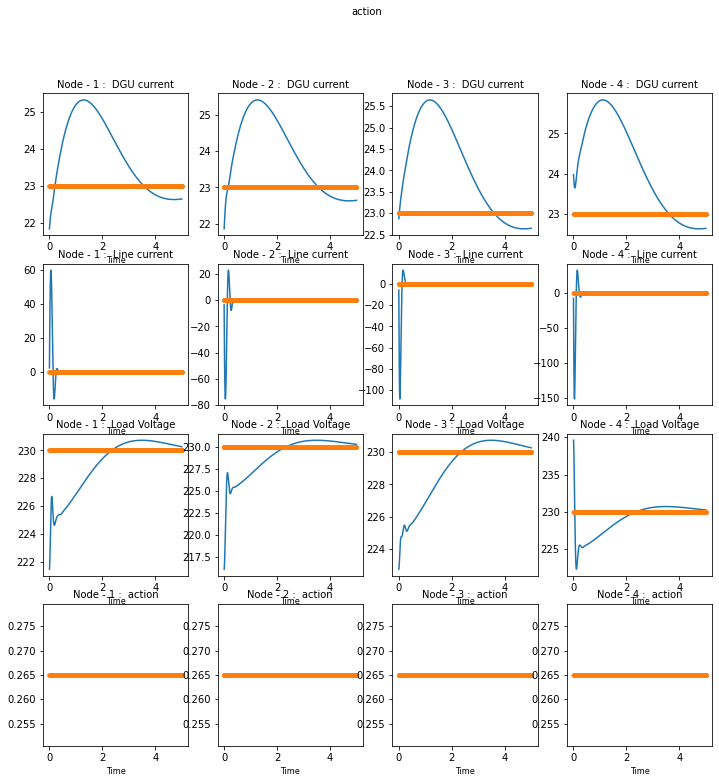

In [ ]:
#collecting samples
env = Buck_micrgrid(dt =1e-3)

print(env.reset())

obs = []
N_steps = int(5e3)
for i in range(N_steps):
    s, r, _, _ = env.step(env.action_des)
    obs.append(s)
    #print(s)

env.plot(savefig_filename = 'temp')

In [ ]:
traz = np.concatenate(env.state_trajectory).reshape((env.count_steps ,env.observation_space.shape[0]))
act_traz = np.concatenate(env.action_trajectory).reshape((env.count_steps ,env.action_space.shape[0]))
temp = np.concatenate([traz, act_traz], axis = 1)
print(np.shape(traz), np.shape(act_traz), np.shape(temp))

(5000, 12) (5000, 4) (5000, 16)


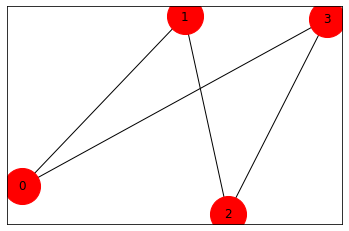

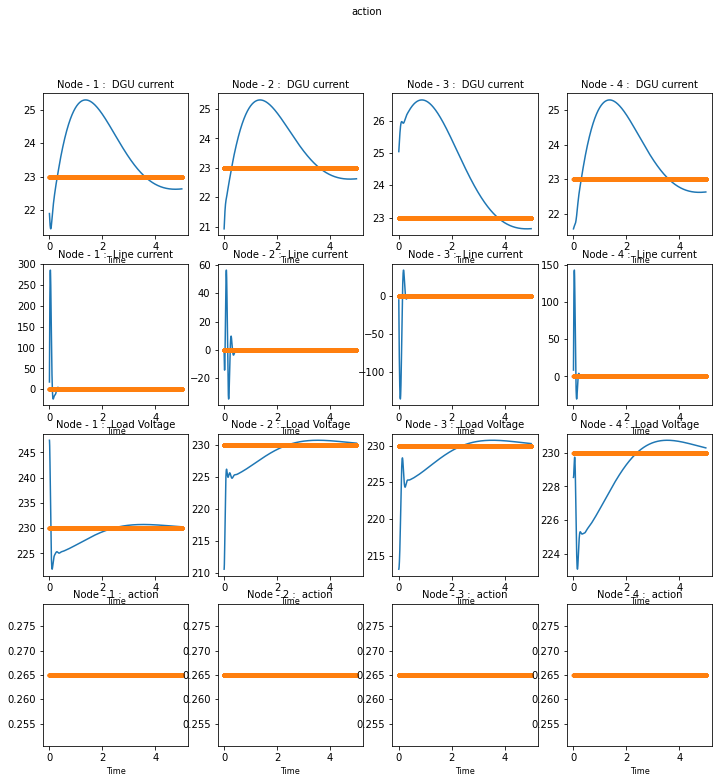

In [ ]:
env.network_graph()

env.plot()

## Testing for some other steady state

In [ ]:
print(env.reset())

obs = []
N_steps = int(1e5)
for i in range(N_steps):
    s, r, _, _ = env.step(env.action_des - 0.1)
    obs.append(s)
    #print(s)

trajectory = np.concatenate(obs).reshape((N_steps ,env.observation_space.shape[0]))

[ 21.0839009   22.21324719  24.39141057  24.88229357   0.
   0.           0.           0.         238.71759467 247.64886773
 229.87938554 230.85645793]


KeyboardInterrupt: ignored

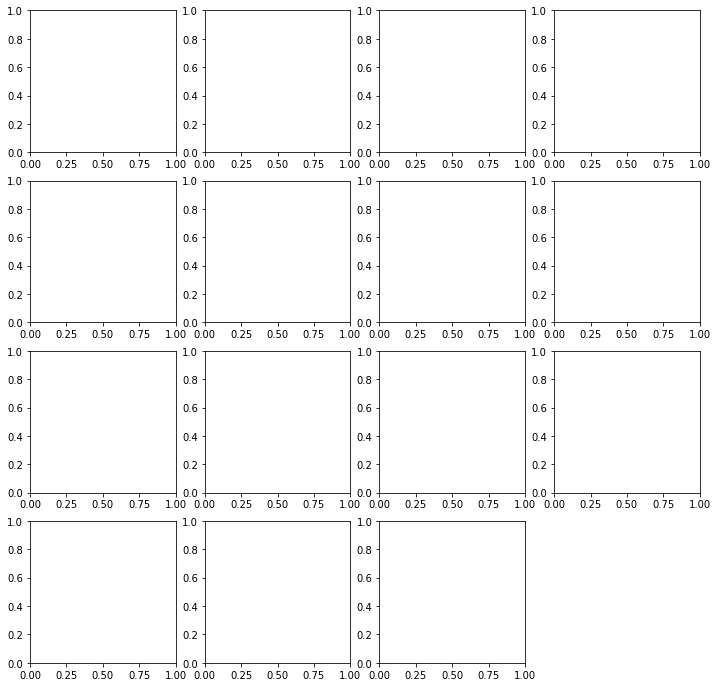

In [ ]:
#plot_signals(trajectory, env.Ides, env.Itdes, env.Vdes, dt = 1e-5)
env.plot()

##State measurements of each node

In [ ]:
for j in range(4):
    node_state, node_reward = env.get_node(j)
    print('Node -- {}, state: {}, reward:{:f}'.format(j, node_state, node_reward))

Node -- 0, state: [ 21.175697 211.82335 ], reward:-330.390642
Node -- 1, state: [ 21.175682 211.82336 ], reward:-330.390087
Node -- 2, state: [ 21.175667 211.82338 ], reward:-330.389532
Node -- 3, state: [ 21.175667 211.82338 ], reward:-330.389532


#utils


In [3]:
import numpy as np
from collections import deque
#import yaml
import pickle
import os
from datetime import datetime
from shutil import copyfile
import random
import numbers
import functools
import operator



#OU Noise
# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)




# Replay buffer
# Taken from https://github.com/pemami4911/deep-rl/blob/master/ddpg/replay_buffer.py
from collections import deque
import random
import numpy as np

class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0





class Scaler(object):
    """ Generate scale and offset based on running mean and stddev along axis=0
        offset = running mean
        scale = 1 / (stddev + 0.1) / 3 (i.e. 3x stddev = +/- 1.0)
    """

    def __init__(self, obs_dim):
        """
        Args:
            obs_dim: dimension of axis=1
        """
        self.vars = np.zeros(obs_dim)
        self.means = np.zeros(obs_dim)
        self.m = 0
        self.n = 0
        self.first_pass = True

    def update(self, x):
        """ Update running mean and variance (this is an exact method)
        Args:
            x: NumPy array, shape = (N, obs_dim)
        see: https://stats.stackexchange.com/questions/43159/how-to-calculate-pooled-
               variance-of-two-groups-given-known-group-variances-mean
        """
        if self.first_pass:
            self.means = np.mean(x, axis=0)
            self.vars = np.var(x, axis=0)
            self.m = x.shape[0]
            self.first_pass = False
        else:
            n = x.shape[0]
            new_data_var = np.var(x, axis=0)
            new_data_mean = np.mean(x, axis=0)
            new_data_mean_sq = np.square(new_data_mean)
            new_means = ((self.means * self.m) + (new_data_mean * n)) / (self.m + n)
            self.vars = (((self.m * (self.vars + np.square(self.means))) +
                          (n * (new_data_var + new_data_mean_sq))) / (self.m + n) -
                         np.square(new_means))
            self.vars = np.maximum(0.0, self.vars)  # occasionally goes negative, clip
            self.means = new_means
            self.m += n

    def get(self):
        """ returns 2-tuple: (scale, offset) """
        return 1/(np.sqrt(self.vars) + 0.1)/3, self.means


def pprint_test(x):
    print(x)

#Actor, Critic

In [4]:
##---------------------------------------------------------------------------------------------------------------
class CriticNetwork_rnn(object):
    def __init__(self, state_dim, action_dim, action_bound, learning_rate, tau, gamma, params_rnn, params_l1, params_l2, time_steps):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau  = tau
        self.gamma = gamma
        self.params_rnn = params_rnn
        self.params_l1 = params_l1
        self.params_l2 = params_l2
        self.time_steps = time_steps
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        #Critic Network and parameters
        self.inputs_state, self.inputs_action, self.out = self.create_critic_network()
        self.critic_model = keras.Model(inputs=[self.inputs_state, self.inputs_action], outputs=self.out, name='critic_network')
        self.network_params = self.critic_model.trainable_variables

        #Target Critic Network and parameters
        self.target_inputs_state, self.target_inputs_action, self.target_out = self.create_critic_network()
        self.target_critic_model = keras.Model(inputs=[self.target_inputs_state, self.target_inputs_action], outputs=self.target_out, name='target_critic_network')
        self.target_network_params = self.target_critic_model.trainable_variables
        
        #initalizing the target params with then network params
        for i in range(len(self.target_network_params)):
            self.target_network_params[i].assign(self.network_params[i])

        #gradients of Q function with respect to actions
    
    def create_critic_network(self):
        inputs_state = Input(shape = (self.time_steps, self.state_dim), batch_size = None, name = "critic_input_state")
        inputs_action = Input(shape = ( self.action_dim,), batch_size = None, name = "critic_input_action")
        w_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03, seed=None)

        #LSTM layer
        lstm_net = layers.GRU(units = self.params_rnn, return_sequences=False, return_state=False)(inputs_state)
        
        #first hidden layer
        net_state = layers.Dense(self.params_l1, name = 'critic_dense_1', kernel_initializer = w_init)(lstm_net)
        net_state = layers.BatchNormalization()(net_state)
        net_state = layers.Activation(activation=tf.nn.relu)(net_state)

        # second hidden layer
        net_state = layers.Dense(self.params_l2, name = 'critic_dense_2_state', kernel_initializer = w_init)(net_state)
        net_action = layers.Dense(self.params_l2, name = 'critic_dense_2_action', kernel_initializer = w_init)(inputs_action)
        #net = layers.Add()([net_state, net_action])
        net = layers.concatenate([net_state, net_action])

        net = layers.Dense(self.params_l2, name = 'critic_dense_3_action', kernel_initializer = w_init)(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation(activation=tf.nn.relu)(net)

        #w_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03, seed=None)
        out = layers.Dense(1, name = 'Q_val', kernel_initializer = w_init)(net)
        return inputs_state, inputs_action, out

    def update_target_network(self):
        self.update_target_network_params = [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) + tf.multiply(self.target_network_params[i], 1-self.tau)) for i in range(len(self.target_network_params))]

    def train(self, input_state, input_actions, predicted_q_val):
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            prediction = self.critic_model([input_state, input_actions])
            #print('predicted_q_val', np.shape(predicted_q_val))
            #print('prediction', np.shape(prediction))
            loss = tf.keras.losses.MSE(prediction, predicted_q_val)
        gradients = tape.gradient(loss, self.network_params)
        self.optimizer.apply_gradients(zip(gradients, self.network_params))
        return self.critic_model([input_state, input_actions])
  
    def action_gradient(self, input_state, input_actions):
        var = tf.constant(input_actions)
        with tf.GradientTape(watch_accessed_variables=False) as tape_a:
            tape_a.watch(var)
            prediction_a = self.critic_model([input_state, var])
        return tape_a.gradient(prediction_a, var)
  
    def predict(self, inputs_state, inputs_actions):
        return self.critic_model([inputs_state, inputs_actions])
  
    def predict_target(self, inputs_state, inputs_actions):
        return self.target_critic_model([inputs_state, inputs_actions])


In [11]:
class ActorNetwork_rnn(object):
    def __init__(self, state_dim, action_dim, action_bound, learning_rate, tau, batch_size, params_rnn, params_l1, params_l2, time_steps):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau  = tau
        self.batch_size = batch_size
        self.params_rnn = params_rnn
        self.params_l1 = params_l1
        self.params_l2 = params_l2
        self.time_steps = time_steps
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        #actor network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()
        self.actor_model = keras.Model(inputs=self.inputs, outputs=self.scaled_out, name='actor_network')
        self.network_params = self.actor_model.trainable_variables

        #target actor network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()
        self.target_actor_model = keras.Model(inputs=self.target_inputs, outputs=self.target_scaled_out, name='target_actor_network')
        self.target_network_params = self.target_actor_model.trainable_variables

        #initalizing the target params with then network params
        for i in range(len(self.target_network_params)):
            self.target_network_params[i].assign(self.network_params[i])


    def create_actor_network(self):
        inputs = Input(shape = (self.time_steps, self.state_dim), batch_size = None, name = "actor_input_state")
        w_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03, seed=None)

        lstm_net = layers.GRU(
            units= self.params_rnn, 
            return_sequences=False, 
            return_state=False, 
            name = 'actor_rnn', 
            #kernel_initializer = w_init
            )(inputs)

        net = layers.Dense(self.params_l1, name = 'actor_dense_1', kernel_initializer = w_init)(lstm_net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation(activation=tf.nn.relu)(net)

        net = layers.Dense(self.params_l2, name = 'actor_dense_2', kernel_initializer = w_init)(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation(activation='tanh')(net)
        
        
        out = layers.Dense(self.action_dim, activation='tanh', name = 'actor_dense_3', kernel_initializer = w_init)(net)
        scaled_out = tf.multiply(out, self.action_bound, name = "actions_scaling")
        return inputs, out, scaled_out
  
    def update_target_network(self):
        self.update_target_network_params = [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) + tf.multiply(self.target_network_params[i], 1-self.tau)) for i in range(len(self.target_network_params))]
  
    def train(self, inputs, a_gradient):
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            prediction = self.actor_model(inputs)
        unnormalized_actor_gradients = tape.gradient(prediction, self.network_params, output_gradients = -a_gradient)
        actor_gradients = list(map(lambda x: tf.math.divide(x, self.batch_size), unnormalized_actor_gradients))
        self.optimizer.apply_gradients(zip(actor_gradients, self.network_params))
    
    def predict(self, inputs):
        return self.actor_model(inputs)

    def predict_target(self, inputs):
        return self.target_actor_model(inputs)


#Train

In [6]:
nodes = 4
obs, obs_scaled, actions, rewards = [[] for _ in range(nodes)], [[] for _ in range(nodes)], [[] for _ in range(nodes)], [[] for _ in range(nodes)]
env.reset()
a = [env.action_des]
for _ in range(args['time_steps']):
    for node in range(nodes):
        node_state, node_reward = env.get_node(node)
        if False:
            var, mean = scaler[node].get()
        else:
            var, mean = 1.0, 0.0
        obs[node].append(np.float32(node_state))
        obs_scaled[node].append(np.float32((node_state - mean) * var))
        actions[node].append(a[node])
        rewards[node].append(node_reward)
    env.step(a)
for node in range(nodes):
    node_state, node_reward = env.get_node(node)
    if False:
        var, mean = scaler[node].get()
    else:
        var, mean = 1.0, 0.0
    obs[node].append(np.float32(node_state))
    obs_scaled[node].append(np.float32((node_state - mean) * var))
    actions[node].append(a[node])
    rewards[node].append(node_reward)
# print(np.shape(obs), obs)
# print(np.shape(obs_scaled), obs_scaled)
# print(np.shape(actions), actions)
# print(np.shape(rewards), rewards)
a_nodes = []
for node in range(nodes):
    S_0 = obs_scaled[node][-args['time_steps']: ]
    a = actor[node].predict(np.reshape(S_0, (1, args['time_steps'], args['state_dim'])))
    print(np.shape(S_0),S_0)
    print(a)
    a_nodes.append(a[0])

s, r, terminal, _  = env.step(a_nodes)
node_rewards = []
for node in range(nodes):
    node_state, node_reward = env.get_node(node)
    if False:
        var, mean = scaler[node].get()
    else:
        var, mean = 1.0, 0.0
    obs[node].append(np.float32(node_state))
    obs_scaled[node].append(np.float32((node_state - mean) * var))
    actions[node].append(a_nodes[node])
    rewards[node].append(node_reward)
    node_rewards.append(node_reward)

temp_replay_buffer1 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
S_2 = obs_scaled[-args['time_steps']: ]
for _ in range(args['mini_batch_size']+1):
    for node in range(nodes):
        temp_replay_buffer1.add(S_0[node], np.reshape(a_nodes[node], (actor[node].action_dim,)), node_rewards[node], terminal, S_2[node])
s_batch, a_batch, r_batch, t_batch, s2_batch = temp_replay_buffer1.sample_batch(args['mini_batch_size'])

NameError: ignored

In [ ]:
temp_a = [0,1,2,3,4,5]
print(temp_a[-2:])
print(temp_a[-3:-1])

[4, 5]
[3, 4]


In [14]:
def train_rnn(env, test_env, args, actors, critics, reward_result, scaler):
    writer = tf.summary.create_file_writer(logdir = args['summary_dir'])

    nodes = 4
    
    
    paths = list()

    # Initialize target network weights
    for node in range(nodes):
        actors[node].update_target_network()
        critics[node].update_target_network()
    
    # Initialize replay memory
    replay_buffer1 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
    replay_buffer2 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
    replay_buffer3 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
    replay_buffer4 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
    replay_buffers = [replay_buffer1, replay_buffer2, replay_buffer3, replay_buffer4]


    for i in range(args['max_episodes']):
        #resetting the environments
        test_env.reset()
        env.reset()

        
        ep_reward = 0
        ep_ave_max_q = 0

        #initializing the lists
        obs, obs_scaled, actions, rewards = [[] for _ in range(nodes)], [[] for _ in range(nodes)], [[] for _ in range(nodes)], [[] for _ in range(nodes)]

        #generating T initial states, to use them in RNN's, and appending them to the lists        
        a = env.action_des
        for steps in range(args['time_steps']+1):
            for node in range(nodes):
                node_state, node_reward = env.get_node(node)
                if args['scaling']:
                    var, mean = scaler[node].get()
                else:
                    var, mean = 1.0, 0.0
                obs[node].append(np.float32(node_state))
                obs_scaled[node].append(np.float32((node_state - mean) * var))
                actions[node].append([a[node]])
                rewards[node].append(node_reward)
            if steps < args['time_steps']:
                env.step(a)

        if i%10 ==0:
            save_weights(actors, critics)
        #running the episode
        for j in range(args['max_episode_len']):

            #Compute the exploration noise annealing
            noise = np.random.normal(0, args['noise_var']/((j/100)+1))

            #compute the actions for each node and collect below
            a_nodes = []
            for node in range(nodes):
                #first we collect the last #time_steps states of a node
                S_0 = obs_scaled[node][-args['time_steps']: ]
                #using this state we predict the new action and add the exploration noise
                a_node = actors[node].predict(np.reshape(S_0, (1, args['time_steps'], args['state_dim']))) + noise
                # action should be inbetween -1 and 1, so we clip it
                a_node = np.clip(a_node[0], -args['action_bound'], args['action_bound'])
                a_nodes.append(a_node[0])

            #we take step using this action
            s2, r, terminal, info = env.step(a_nodes)

            #collect reward of each and append the new state (scaled) into the buffer
            node_rewards = []
            for node in range(nodes):
                node_state, node_reward = env.get_node(node)
                if args['scaling']:
                    var, mean = scaler[node].get()
                else:
                    var, mean = 1.0, 0.0
                obs[node].append(np.float32(node_state))
                obs_scaled[node].append(np.float32((node_state - mean) * var))
                actions[node].append(a_nodes[node])
                rewards[node].append(node_reward)
                node_rewards.append(node_reward)

            #for each node -- add the current state, action, reward, terminal and the previous state to the replay buffer
            for node in range(nodes):
                S_0 = obs_scaled[node][-args['time_steps']-1: -1]
                S_1 = obs_scaled[node][-args['time_steps']: ]
                replay_buffers[node].add(S_0, np.reshape(a_nodes[node], (actors[node].action_dim,)), node_rewards[node], terminal, S_1)
            
            for node, replay_buffer, critic, actor in zip(range(nodes), replay_buffers, critics, actors):
                if replay_buffer.size() >= int(args['mini_batch_size']):
                    s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(int(args['mini_batch_size']))

                    target_q = np.array(critic.predict_target(s2_batch, actor.predict_target(s2_batch)))
                    y = []
                    for k in range(args['mini_batch_size']):
                        if t_batch[k]:
                            y.append(r_batch[k])
                        else:
                            y.append(r_batch[k] + critic.gamma * np.array(target_q[k]))

                    temp = np.reshape(y, (args['mini_batch_size'], 1))

                    predicted_q_value = critic.train(s_batch, a_batch, temp.astype('float32'))

                    ep_ave_max_q += np.amax(predicted_q_value)

                    a_outs = actor.predict(s_batch)
                    grads = critic.action_gradient(s_batch, a_outs)
                    
                    actor.train(s_batch, grads)
                    actor.update_target_network()
                    critic.update_target_network()

            ep_reward += r

            #print(i, j)
            #print(np.shape(obs), obs)

            if j+1 == args['max_episode_len']:
                with writer.as_default():
                    tf.summary.scalar("Reward", ep_reward, step = i)
                    tf.summary.scalar("Qmax Value", ep_ave_max_q / float(j), step = i)
                    writer.flush()
                print('| Reward: {:.4f} | Episode: {:d} | Qmax: {:.4f}'.format((ep_reward), i, (ep_ave_max_q / float(j))))
                reward_result[i] = ep_reward
                obs_concat = []
                for node in range(nodes):
                    obs_concat.append(np.concatenate(obs[node]).reshape((args['max_episode_len']+args['time_steps']+1,2)))
                    #print(np.shape(obs_concat), obs_concat)

                path = {
                    "Observation":obs_concat, 
                    "Action":np.concatenate(actions), 
                    "Reward":np.asarray(rewards)
                    }
                paths.append(path)
                env.plot()
                #test_s = test_env.reset()
                # if i+1 == args['max_episodes']:
                #     env.plot()
                #     test_s = test_env.reset()
                #     for _ in range(1000):
                #         test_s_scaled = np.float32((test_s - mean) * var) 
                #         test_a = actor.predict(np.reshape(test_s_scaled,(1,actor.state_dim)))
                #         test_s, r, terminal, info = test_env.step(test_a[0])
                #     test_env.plot()
                break
    return [paths, reward_result] 

##args

In [7]:
args = {
    'summary_dir' : '/content/sample_data',
    'use_gpu': True,
    'buffer_size' : 1000000,
    'random_seed' : 1754,
    'max_episodes': 500,
    'max_episode_len' : 1200,
    'mini_batch_size': 1200,
    'actor_lr':0.0001,
    'critic_lr':0.001,
    'tau':0.001,
    'state_dim':2,
    'action_dim':1,
    'action_bound':1,
    'gamma':0.999,
    'actor_rnn':20,
    'actor_l1':400,
    'actor_l2':300,
    'critic_rnn':20,
    'critic_l1':400,
    'critic_l2':300,
    'discretization_time': 1e-3,
    'noise_var':0.0925,
    'scaling': True,
    'save_model':True,
    'load_model':True,
    'time_steps':2
}

In [8]:
test_env = Buck_micrgrid(dt = args['discretization_time'])
env = Buck_micrgrid(dt = args['discretization_time'])

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
test_s = test_env.reset()
test_obs, test_act, test_rew =[], [], []
test_nodes = [[],[],[],[]]
test_steps = 10**5
for test_i in range(test_steps):
    test_env.step(np.random.uniform(-1,1, 4))
    for i in range(4):
        node_s, _ = test_env.get_node(i)
        test_nodes[i].append(node_s)

scale1 = Scaler(2)
scale2 = Scaler(2)
scale3 = Scaler(2)
scale4 = Scaler(2)
scales = [scale1, scale2, scale3, scale4]

for i in range(4):
    scales[i].update(np.concatenate(test_nodes[i]).reshape((test_steps ,2)))
    print(scales[i].get())

(array([0.09458059, 0.07592737], dtype=float32), array([ 17.832588, 182.1276  ], dtype=float32))
(array([0.09577978, 0.07611153], dtype=float32), array([ 17.847025, 182.12674 ], dtype=float32))
(array([0.09520554, 0.07596333], dtype=float32), array([ 17.840063, 182.1278  ], dtype=float32))
(array([0.09407832, 0.07443718], dtype=float32), array([ 17.826494, 182.1357  ], dtype=float32))


In [12]:
actor1 = ActorNetwork_rnn(
    state_dim = args['state_dim'],
    action_dim = args['action_dim'], 
    action_bound=args['action_bound'], 
    learning_rate = args['actor_lr'], 
    tau = args['tau'], 
    batch_size = args['mini_batch_size'],
    params_rnn = args['actor_rnn'],
    params_l1 = args['actor_l1'],
    params_l2 = args['actor_l2'],
    time_steps = args['time_steps']
    )
actor2 = ActorNetwork_rnn(
    state_dim = args['state_dim'],
    action_dim = args['action_dim'], 
    action_bound=args['action_bound'], 
    learning_rate = args['actor_lr'], 
    tau = args['tau'], 
    batch_size = args['mini_batch_size'],
    params_rnn = args['actor_rnn'],
    params_l1 = args['actor_l1'],
    params_l2 = args['actor_l2'],
    time_steps = args['time_steps']
    )
actor3 = ActorNetwork_rnn(
    state_dim = args['state_dim'],
    action_dim = args['action_dim'], 
    action_bound=args['action_bound'], 
    learning_rate = args['actor_lr'], 
    tau = args['tau'], 
    batch_size = args['mini_batch_size'],
    params_rnn = args['actor_rnn'],
    params_l1 = args['actor_l1'],
    params_l2 = args['actor_l2'],
    time_steps = args['time_steps']
    )
actor4 = ActorNetwork_rnn(
    state_dim = args['state_dim'],
    action_dim = args['action_dim'], 
    action_bound=args['action_bound'], 
    learning_rate = args['actor_lr'], 
    tau = args['tau'], 
    batch_size = args['mini_batch_size'],
    params_rnn = args['actor_rnn'],
    params_l1 = args['actor_l1'],
    params_l2 = args['actor_l2'],
    time_steps = args['time_steps']
    )

critic1 = CriticNetwork_rnn(
    state_dim = args['state_dim'], 
    action_dim = args['action_dim'], 
    action_bound = args['action_bound'], 
    learning_rate = args['critic_lr'], 
    tau = args['tau'], 
    gamma = args['gamma'],
    params_rnn = args['critic_rnn'],
    params_l1 = args['critic_l1'],
    params_l2 = args['critic_l2'],
    time_steps = args['time_steps']
    )
critic2 = CriticNetwork_rnn(
    state_dim = args['state_dim'], 
    action_dim = args['action_dim'], 
    action_bound = args['action_bound'], 
    learning_rate = args['critic_lr'], 
    tau = args['tau'], 
    gamma = args['gamma'],
    params_rnn = args['critic_rnn'],
    params_l1 = args['critic_l1'],
    params_l2 = args['critic_l2'],
    time_steps = args['time_steps']
    )
critic3 = CriticNetwork_rnn(
    state_dim = args['state_dim'], 
    action_dim = args['action_dim'], 
    action_bound = args['action_bound'], 
    learning_rate = args['critic_lr'], 
    tau = args['tau'], 
    gamma = args['gamma'],
    params_rnn = args['critic_rnn'],
    params_l1 = args['critic_l1'],
    params_l2 = args['critic_l2'],
    time_steps = args['time_steps']
    )
critic4 = CriticNetwork_rnn(
    state_dim = args['state_dim'], 
    action_dim = args['action_dim'], 
    action_bound = args['action_bound'], 
    learning_rate = args['critic_lr'], 
    tau = args['tau'], 
    gamma = args['gamma'],
    params_rnn = args['critic_rnn'],
    params_l1 = args['critic_l1'],
    params_l2 = args['critic_l2'],
    time_steps = args['time_steps']
    )

actors = [actor1, actor2, actor3, actor4]
critics = [critic1, critic2, critic3, critic4]

In [ ]:
critic1.critic_model.summary()

Model: "critic_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
critic_input_state (InputLayer) [(None, 2, 2)]       0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 20)           1440        critic_input_state[0][0]         
__________________________________________________________________________________________________
critic_dense_1 (Dense)          (None, 400)          8400        gru[0][0]                        
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 400)          1600        critic_dense_1[0][0]             
_____________________________________________________________________________________

In [ ]:
for node in range(4):
    if args['load_model']:
        if os.path.isfile(args['summary_dir'] + "/actor_weights.h5"):
            print('loading actor {} weights'.format(node+1))
            actors[node].actor_model.load_weights(args['summary_dir'] + "/actor_weights.h5")
        if os.path.isfile(args['summary_dir'] + "/target_actor_weights.h5"):
            print('loading actor {} target weights'.format(node+1))
            actors[node].actor_model.load_weights(args['summary_dir'] + "/target_actor_weights.h5")
        if os.path.isfile(args['summary_dir'] + "/critic_weights.h5"):
            print('loading critic {} weights'.format(node+1))
            critics[node].critic_model.load_weights(args['summary_dir'] + "/critic_weights.h5")
        if os.path.isfile(args['summary_dir'] + "/target_critic_weights.h5"):
            print('loading critic {} target weights'.format(node+1))
            critics[node].critic_model.load_weights(args['summary_dir'] + "/target_critic_weights.h5")

In [ ]:
test_s = test_env.reset()
test_obs=[]
test_steps = int(1/args['discretization_time'])
test_episodes = 2000
for _ in range(test_episodes):
    u = np.random.uniform(-1,1)
    for _ in range(test_steps):
        s, _,_,_ = test_env.step(u)
        test_obs.append(s)
scaler = Scaler(2)
scaler.update(np.concatenate(test_obs).reshape((test_steps*test_episodes,env.observation_space.shape[0])))
var, mean = scaler.get()
print(var, mean)

| Reward: -168376.9092 | Episode: 0 | Qmax: -0.0000


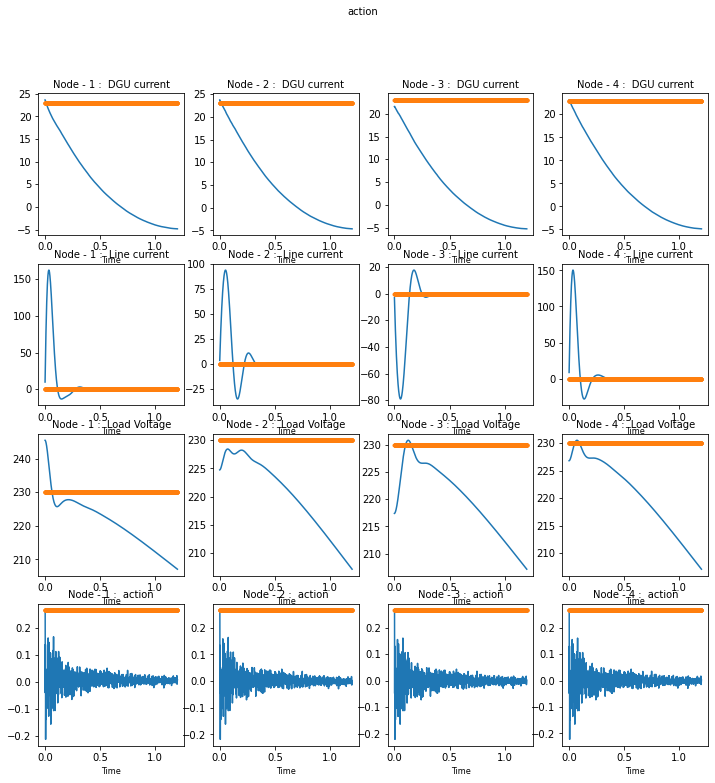

In [ ]:
reward_result = np.zeros(2500)
def save_weights(actors, critics):
    paths = '/content/sample_data'
    for node in range(4):
        actors[node].actor_model.save_weights(
            filepath = paths + "/actor_"+ str(node) + "_weights.h5",
            overwrite=True,
            save_format='h5')
        actors[node].target_actor_model.save_weights(
            filepath = paths + "/target_actor_"+ str(node) + "_weights.h5",
            overwrite=True,
            save_format='h5')
        critics[node].critic_model.save_weights(
            filepath = paths + "/critic_"+ str(node) + "_weights.h5",
            overwrite=True,
            save_format='h5')
        critics[node].target_critic_model.save_weights(
            filepath = paths + "/target_critic_"+ str(node) + "_weights.h5",
            overwrite=True,
            save_format='h5')
        
train_rnn(env, test_env, args, actors, critics, reward_result, scales)

##Save model


In [ ]:
paths = '/content/sample_data'
for node in range(4):
    actors[node].actor_model.save_weights(
        filepath = paths + "/actor_"+ str(node) + "_weights.h5",
        overwrite=True,
        save_format='h5')
    actors[node].target_actor_model.save_weights(
        filepath = paths + "/target_actor_"+ str(node) + "_weights.h5",
        overwrite=True,
        save_format='h5')
    critics[node].critic_model.save_weights(
        filepath = paths + "/critic_"+ str(node) + "_weights.h5",
        overwrite=True,
        save_format='h5')
    critics[node].target_critic_model.save_weights(
        filepath = paths + "/target_critic_"+ str(node) + "_weights.h5",
        overwrite=True,
        save_format='h5')

NameError: ignored

In [ ]:
for node in range(4):
    print(str(node))

0
1
2
3


In [ ]:
actors

NameError: ignored

In [ ]:
10%10==0

True